In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import keras
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Activation, BatchNormalization, Dense, Dropout, Flatten, Input
from keras.layers import Conv2D, Dense, GlobalAveragePooling2D, MaxPooling2D
from keras import backend as K
from sklearn.model_selection import train_test_split

import tensorflow as tf

import os
import pickle
import numpy as np

print("Tensorflow version: {}".format(tf.__version__))
print("Keras version: {}".format(keras.__version__))

Using TensorFlow backend.


Tensorflow version: 1.1.0
Keras version: 2.0.8


In [2]:
batch_size = 32
img_height, img_width = 299, 299

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

validation_datagen = ImageDataGenerator(rescale=1./255)

In [3]:
train_generator = train_datagen.flow_from_directory(
        'data/train',
        target_size=(img_height, img_width),
        batch_size=batch_size)

validation_generator = validation_datagen.flow_from_directory(
        'data/validation',
        target_size=(img_height, img_width),
        batch_size=batch_size)

Found 41539 images belonging to 132 classes.
Found 7331 images belonging to 132 classes.


In [4]:
num_epochs = 1
num_classes = 132

In [5]:
# create the base pre-trained model
base_model = InceptionV3(input_tensor=Input(shape=(img_height, img_width, 3)), weights='imagenet', include_top=False)

In [6]:
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5, name='Dropout_01')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(num_classes, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer=keras.optimizers.rmsprop(),
              loss=keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

# train the model on the new data for a few epochs
model.fit_generator(train_generator,
                    steps_per_epoch=train_generator.samples // batch_size,
                    epochs=num_epochs,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.samples // batch_size,
                    workers=4)

# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
model.compile(optimizer=keras.optimizers.SGD(lr=0.0001, momentum=0.9),
              loss=keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
history = model.fit_generator(train_generator,
                    steps_per_epoch=train_generator.samples // batch_size,
                    epochs=num_epochs,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.samples // batch_size,
                    workers=4)

Epoch 1/1
1298/1298 [==============================] - 579s - loss: 2.8995 - acc: 0.3428 - val_loss: 2.2909 - val_acc: 0.4696
0 input_1
1 conv2d_1
2 batch_normalization_1
3 activation_1
4 conv2d_2
5 batch_normalization_2
6 activation_2
7 conv2d_3
8 batch_normalization_3
9 activation_3
10 max_pooling2d_1
11 conv2d_4
12 batch_normalization_4
13 activation_4
14 conv2d_5
15 batch_normalization_5
16 activation_5
17 max_pooling2d_2
18 conv2d_9
19 batch_normalization_9
20 activation_9
21 conv2d_7
22 conv2d_10
23 batch_normalization_7
24 batch_normalization_10
25 activation_7
26 activation_10
27 average_pooling2d_1
28 conv2d_6
29 conv2d_8
30 conv2d_11
31 conv2d_12
32 batch_normalization_6
33 batch_normalization_8
34 batch_normalization_11
35 batch_normalization_12
36 activation_6
37 activation_8
38 activation_11
39 activation_12
40 mixed0
41 conv2d_16
42 batch_normalization_16
43 activation_16
44 conv2d_14
45 conv2d_17
46 batch_normalization_14
47 batch_normalization_17
48 activation_14
49 act

In [9]:
# Evaluate model with test data set and share sample prediction results
evaluation = model.evaluate_generator(validation_generator,
                                      steps=validation_generator.samples // batch_size,
                                      workers=4)
print('Model Accuracy = %.2f' % (evaluation[1]))
print('Model Loss = %.2f' % (evaluation[0]))

Model Accuracy = 0.57
Model Loss = 1.82


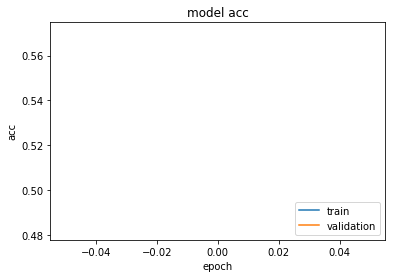

In [10]:
def plot_train(hist):
    h = hist.history
    if 'acc' in h:
        meas='acc'
        loc='lower right'
    else:
        meas='loss'
        loc='upper right'
    plt.plot(hist.history[meas])
    plt.plot(hist.history['val_'+meas])
    plt.title('model '+meas)
    plt.ylabel(meas)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc=loc)
    
plot_train(history)